In this notebook we evaluate the explainability of two models : KAN and Random Forest, on the Bikesharing dataset. To do this, we'll be using two popular methods, SHAP and PFI.

In [ ]:
!pip install git+https://github.com/KindXiaoming/pykan.git #Importing the KAN code from github

  Cloning https://github.com/KindXiaoming/pykan.git to c:\users\lamia\appdata\local\temp\pip-req-build-_qv5dgek
  Resolved https://github.com/KindXiaoming/pykan.git to commit 00a9077100b9783304b1df95de47b7344e3e1eec
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pykan: filename=pykan-0.2.8-py3-none-any.whl size=78446 sha256=f41c506f3edcb1c626b2321c73e06f2c30494dbef050e1e4c9dbb734967515eb
  Stored in directory: C:\Users\lamia\AppData\Local\Temp\pip-ephem-wheel-cache-4qows7c9\wheels\e5\c9\d6\a9b7aad8b3f7e1dde415462c7dd48df332ec616b149d51bcb8
Successfully built pykan
  Attempting uninstall: pykan
    Found existing installation: pykan 0.2.7
    Uninstalling pykan-0.2.7:
      Successfully uninstalled pykan-0.2.7


  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan.git 'C:\Users\lamia\AppData\Local\Temp\pip-req-build-_qv5dgek'


Import packages

In [2]:
import torch
from kan import KAN

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap

Data Analysis and Cleaning

In [3]:
df = pd.read_csv("C:/Users/lamia/Desktop/Test KAN/Bike-sharing/hour.csv")

In [4]:
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [5]:
df.drop(['instant', 'dteday', 'atemp', 'registered', 'casual'], axis=1, inplace=True)
df.dropna(inplace=True)
# Prepare input features and labels
X = df.drop('cnt', axis=1)
y = df['cnt']

# Ensure X and y do not contain NaNs
X.dropna(inplace=True)
y.dropna(inplace=True)
y = y[X.index]  # Align y with the remaining X

In [6]:
# Splitting the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

In [7]:
# Drop NaNs in X_train, X_val, and X_test
X_train.dropna(inplace=True)
X_val.dropna(inplace=True)
X_test.dropna(inplace=True)

y_train.dropna(inplace=True)
y_val.dropna(inplace=True)
y_test.dropna(inplace=True)

In [8]:
# transforming the data
train_input = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
train_label = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
val_input = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
val_label = torch.tensor(y_val.to_numpy(), dtype=torch.float32).view(-1, 1)
test_input = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
test_label = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)


In [9]:
# creating the dataset
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'val_input': val_input,
    'val_label': val_label,
    'test_input': test_input,
    'test_label': test_label
}

Random Forest Model

In [ ]:
# GridSearch to find best parameters

param_grid = {
    "max_depth": [None, 12, 15, 18],
    "min_samples_leaf": [1, 2, 4],
    "n_estimators": [100, 200, 300],
    "max_samples": [0.8, 0.9, 0.99]
}


rf = RandomForestRegressor(random_state=1)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)
# Fit the model with hyperparameter tuning
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': None, 'max_samples': 0.9, 'min_samples_leaf': 1, 'n_estimators': 300}


In [10]:
# Best model
best_rf_model = RandomForestRegressor(
    max_depth=None,
    max_samples=0.9,
    min_samples_leaf=1,
    n_estimators=300,
    random_state=1
)

# Fit the model
best_rf_model.fit(X_train, y_train)

RandomForestRegressor(max_samples=0.9, n_estimators=300, random_state=1)

In [11]:
# Make predictions using the best model
train_preds_rf = best_rf_model.predict(X_train)
val_preds_rf = best_rf_model.predict(X_val)
test_preds_rf = best_rf_model.predict(X_test)

# Evaluate metrics

print("Train R2 Score:", r2_score(y_train, train_preds_rf))
print("Train MAE:", mean_absolute_error(y_train, train_preds_rf))

print("Validation R2 Score:", r2_score(y_val, val_preds_rf))
print("Validation MAE:", mean_absolute_error(y_val, val_preds_rf))

print("Test R2 Score:", r2_score(y_test, test_preds_rf))
print("Test MAE:", mean_absolute_error(y_test, test_preds_rf))

Train R2 Score: 0.9905872546696741
Train MAE: 10.598475850573138
Validation R2 Score: 0.937695154213167
Validation MAE: 26.907520372501384
Test R2 Score: 0.9424077776907787
Test MAE: 26.15226407535268


PFI for Random Forest

 PFI Feature Importance :
       Feature    Importance      Std Dev
3           hr  44810.429504  2141.654708
6   workingday   8788.636594   551.870755
1           yr   6408.687089   411.449606
8         temp   5948.438874   551.427384
9          hum   1898.190597   208.255690
7   weathersit   1244.025640   165.011478
0       season   1190.878393   110.984668
2         mnth    832.777933   164.435114
5      weekday    607.886513    58.353987
10   windspeed    102.176691    26.585088
4      holiday     83.838916    28.072622


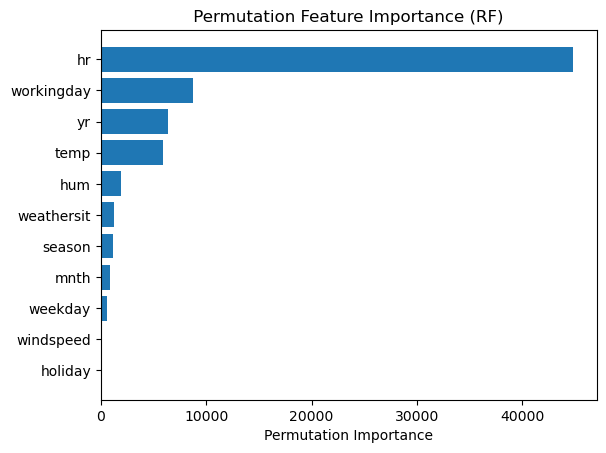

In [13]:
# Sampling data
X_test_sample = X_test.sample(n=1000, random_state=42)
y_test_sample = y_test.sample(n=1000, random_state=42)

# Calculate PFI using permutation_importance from Scikit-learn
pfi_result = permutation_importance(best_rf_model, X_test_sample, y_test_sample, n_repeats=10, random_state=42, scoring='neg_mean_squared_error')

# Create a DataFrame to store the importance results
pfi_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': pfi_result.importances_mean,
    'Std Dev': pfi_result.importances_std
})

# Sort the features by importance
pfi_importances_sorted = pfi_importances.sort_values(by='Importance', ascending=False)


print(" PFI Feature Importance :")
print(pfi_importances_sorted)

plt.barh(pfi_importances_sorted['Feature'], pfi_importances_sorted['Importance'])
plt.xlabel("Permutation Importance")
plt.title(" Permutation Feature Importance (RF) ")
plt.gca().invert_yaxis()
plt.show()

SHAP for Random Forest

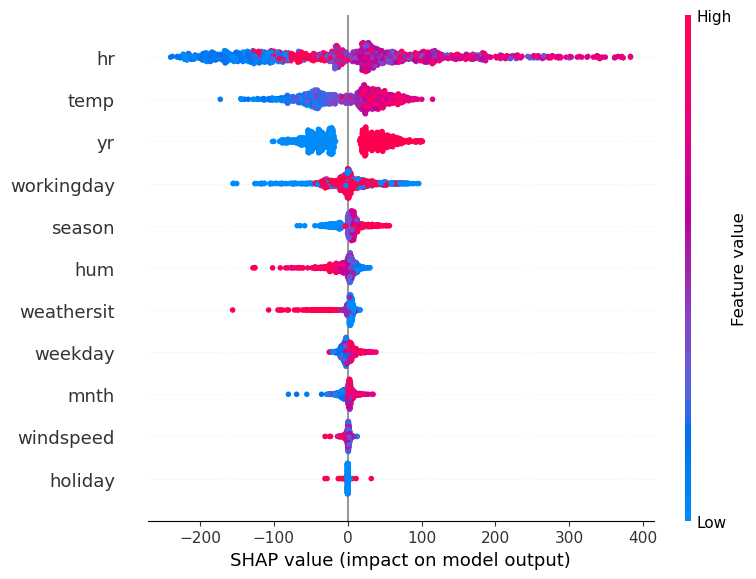

NameError: name 'shap_importances' is not defined

In [14]:

# Initialize SHAP explainer for the Random Forest model
X_test_sample = X_test.sample(n=1000, random_state=42)
explainer = shap.TreeExplainer(best_rf_model)

# Calculate SHAP values for the test set
shap_values = explainer(X_test_sample)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test_sample)


In [ ]:
# Shap importances Dataframe
shap_importances = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': np.abs(shap_values.values).mean(axis=0)
})
shap_importances_sorted = shap_importances.sort_values(by='Importance', ascending=False)

Agreement metric

In [ ]:
# Function to measure greement for the top k features using Jaccard Index
def agreement_metric(top_k_shap, top_k_pfi):
    set_shap = set(top_k_shap)
    set_pfi = set(top_k_pfi)

    intersection = len(set_shap.intersection(set_pfi))
    union = len(set_shap.union(set_pfi))

    score = intersection / union if union != 0 else 0
    return score

In [ ]:
# Define k the number of top features to compare
k = 4

# Extract top k features
top_k_shap = shap_importances_sorted['Feature'][:k]
top_k_pfi = pfi_importances_sorted['Feature'][:k]

score = agreement_metric(top_k_shap, top_k_pfi)
print(f"Agreement metric for the top {k} features using Random Forest: {score:.4f}")

Jaccard Index for the top 4 features using Random Forest: 1.0000


KAN Model

In [ ]:
# Create the KAN model
model = KAN(width=[11, 5, 1], grid=5, k=3, seed=0)  # one hidden layer with 5 neurons

checkpoint directory created: ./model
saving model version 0.0


In [ ]:
results = model.fit(
    {'train_input': train_input, 'train_label': train_label, 'test_input': val_input, 'test_label': val_label},
    opt="LBFGS", steps=50, loss_fn=torch.nn.MSELoss() # MSELoss for regression
)

| train_loss: 8.99e+01 | test_loss: 8.96e+01 | reg: 1.02e+04 | : 100%|█| 50/50 [04:58<00:00,  5.96s/

saving model version 0.1


In [ ]:
# Predictions of train, val and test datasets
test_preds = model.forward(test_input).detach()
test_labels = test_label

train_preds = model.forward(train_input).detach()
train_labels = train_label

val_preds = model.forward(val_input).detach()
val_labels = val_label

# Evaluation metrics
print("Train R2 Score:", r2_score(train_labels.numpy(), train_preds.numpy()))
print("Train MSE:", mean_squared_error(train_labels.numpy(), train_preds.numpy()))

print("Val R2 Score:", r2_score(val_labels.numpy(), val_preds.numpy()))
print("Val MSE:", mean_squared_error(val_labels.numpy(), val_preds.numpy()))

print("Test R2 Score:", r2_score(test_labels.numpy(), test_preds.numpy()))
print("Test MSE:", mean_squared_error(test_labels.numpy(), test_preds.numpy()))

Train R2 Score: 0.7540810159248041
Train MSE: 8075.8335
Val R2 Score: 0.7517446483416751
Val MSE: 8021.499
Test R2 Score: 0.7519277774576953
Test MSE: 8375.294


PFI for KAN

       Feature    Importance
3           hr  34082.140927
8         temp   5323.173197
1           yr   4793.098838
6   workingday   4268.833398
9          hum   1029.401415
2         mnth    739.199247
7   weathersit    331.313203
5      weekday    270.381109
0       season    196.368974
4      holiday     14.625951
10   windspeed    -16.225525


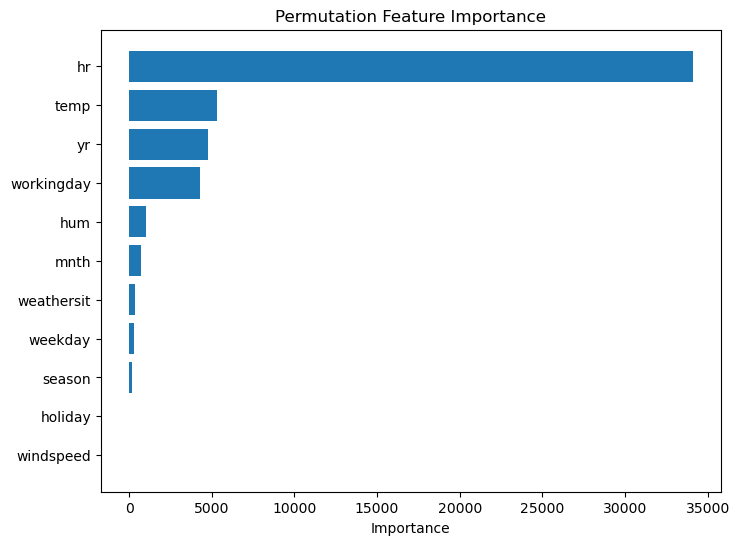

In [ ]:

# Function to evaluate model performance using MSE metric
def evaluate_model(model, X, y):
    model.eval()
    with torch.no_grad():
        predictions = model(torch.tensor(X, dtype=torch.float32)).numpy()
    return mean_squared_error(y, predictions)

# Calculate permutation feature importance (PFI)
def permutation_importance(model, X, y, metric=evaluate_model, n_repeats=10):
    baseline_score = metric(model, X, y)
    importances = np.zeros(X.shape[1])

    for i in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            np.random.shuffle(X_permuted[:, i])
            score = metric(model, X_permuted, y)
            scores.append(score)
        importances[i] = np.mean(scores) - baseline_score

    return importances


# Convert validation data to numpy arrays
X_val_tensor = X_val.to_numpy()
y_val_tensor = y_val.to_numpy()

# Calculate feature importances
pfi_importances_kan = permutation_importance(model, X_val_tensor, y_val_tensor)

# Create DataFrame with feature importances
feature_names = X_train.columns
pfi_importance_kan_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': pfi_importances_kan
}).sort_values(by='Importance', ascending=False)

print(pfi_importances_kan_df)

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.barh(pfi_importances_kan_df['Feature'], pfi_importances_kan_df['Importance'])
plt.xlabel('Importance')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()
plt.show()


SHAP KAN

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\lamia\anaconda3\Lib\site-packages\kan\MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1808.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\lamia\anaconda3\Lib\site-packages\kan\MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1808.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\lamia\anaconda3\Lib\site-packages\kan\MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output nume

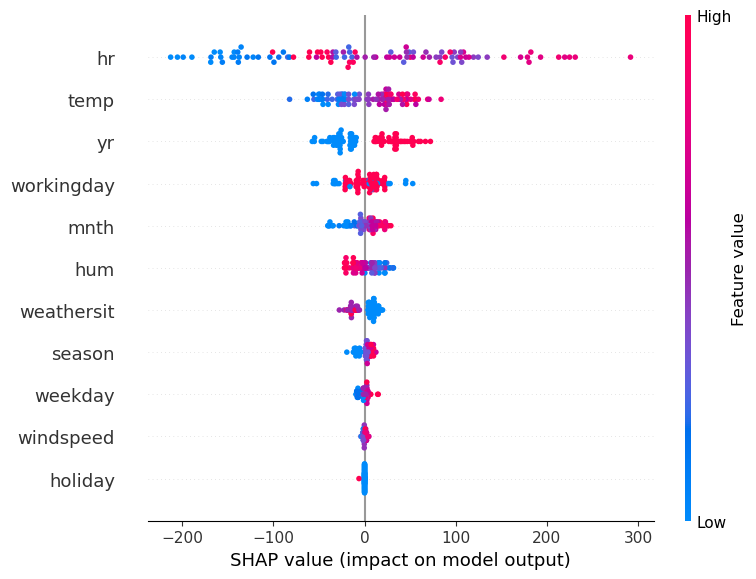

In [ ]:

# Prediction function
def predict(data):
    data_tensor = torch.tensor(data, dtype=torch.float32)
    with torch.no_grad():
        preds = model(data_tensor).numpy()
    return preds

# Sampling data
X_train_subset = X_train.sample(100, random_state=42).to_numpy()
X_test_subset = X_test.sample(100, random_state=42).to_numpy()

explainer = shap.KernelExplainer(predict, X_train_subset)

shap_values = explainer.shap_values(X_test_subset)

if isinstance(shap_values, list):
    shap_values = shap_values[0]

shap_values = np.squeeze(shap_values)

shap_df_kan= pd.DataFrame(shap_values, columns=X_test.columns)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test_subset, feature_names=X_test.columns)

Agreement metric

In [ ]:
#Creating lists of top k features of shap and pfi for KAN
k = 4
top_k_pfi_features_kan = ['hr', 'temp', 'yr', 'workingday']
top_k_shap_features_kan = ['hr', 'temp', 'yr', 'workingday']

# Compute the agreement metric for the top k features
score_kan = agreement_metric(top_k_shap_features_kan, top_k_pfi_features_kan)
print(f"Jaccard Index for the top {k} features using KAN: {score_kan:.4f}")

Jaccard Index for the top 4 features using KAN: 1.0000
